In [1]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw
import pandas as pd
from tqdm import tqdm
epsilon = 1e-3
import torch
from torch.utils.data import DataLoader
from model import TransPathModel, GridData

%matplotlib inline

In [2]:

class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, 1), (-1, -1), (1, -1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [3]:

def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move.
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:
        return 2 ** 0.5
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")

In [4]:

class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i == other.i) and (self.j == other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        if abs(self.f - other.f) < epsilon: # tie-break
            return self.g > other.g
        return self.f < other.f

In [5]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        if not self._open or len(self._open) == 0:
            return None
        best_node = heappop(self._open)
        while self.was_expanded(best_node):
            self._enc_open_dublicates += 1
            if not self._open or len(self._open) == 0:
                return None 
            best_node = heappop(self._open)
        return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [6]:

def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [7]:
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Manhattan distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Manhattan distance between the two cells.
    """
    return abs(abs(i1 - i2) - abs(j1 - j2)) + min(abs(i1 - i2), abs(j1 - j2)) * 2 ** 0.5

In [8]:

def wastar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    heuristic: np.ndarray,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    heuristic : np.ndarray
        Heuristic for estimating the correction factor of heuristic_func.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
    ast.add_to_open(start_node)

    goal_node = Node(goal_i, goal_j)

    while not ast.open_is_empty():
        steps += 1
        best = ast.get_best_node_from_open()
        if not best:
            break
        if goal_node == best:
            return True, best, steps, len(ast), ast.opened, ast.expanded
        neighbours = task_map.get_neighbors(best.i, best.j)
        for neighbour in neighbours:
            cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
            if not ast.was_expanded(cur_node):
                ast.add_to_open(cur_node)
        ast.add_to_closed(best)

    return False, None, steps, len(ast), None, ast.expanded

In [9]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [30]:
dataset_path = './Big_QRs'
model_path = './weights/QRs_big_model_2'
mode = 'cf'
accelerator = "cuda"
devices = [1]
batch_size = 128

test_data = GridData(
        path=f'{dataset_path}/test',
        mode=mode
    )

dataloader = DataLoader(
        test_data, 
        batch_size=batch_size,
        shuffle=False, 
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )

eval_model = TransPathModel().to(torch.device(f'{accelerator}:{devices[-1]}'))
eval_model.load_state_dict(torch.load(model_path, weights_only=True))
eval_model.eval()
predictions = []
for map_design, start, goal, gt_hmap in tqdm(dataloader):
    inputs = torch.cat([map_design, start + goal], dim=1) if mode in ('f', 'nastar') else torch.cat([map_design, goal], dim=1)
    inputs = inputs.to(torch.device(f'{accelerator}:{devices[-1]}'))
    
    with torch.no_grad():
        prediction = (eval_model(inputs) + 1) / 2

    predictions.append(prediction)

predictions = torch.cat(predictions).cpu().detach().numpy()
print(predictions.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.68it/s]


(64000, 1, 64, 64)


In [31]:
np.save(f'{dataset_path}/test/predicted_cf_big_2.npy', predictions)

# Big QRs

In [37]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './Big_QRs/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_big_2.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./Big_QRs_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

/tmp/ipykernel_1341116/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide       | 8431/64000 [00:49<06:01, 153.79it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_1341116/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract     | 14820/64000 [01:27<05:08, 159.37it/s]
  if abs(self.f - other.f) < epsilon: # tie-break
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 64000/64000 [06:16<00:00, 169.99it/s]


In [38]:
df = pd.DataFrame.from_dict(metrics)
df.head()

,expansions_ratio,length_ratio
0,0.349282,1.038179
1,0.495413,1.012089
2,0.531549,1.023565
3,0.341579,1.065245
4,0.422652,1.037299


In [39]:
print((df['expansions_ratio'] < 1).mean())

0.978359375


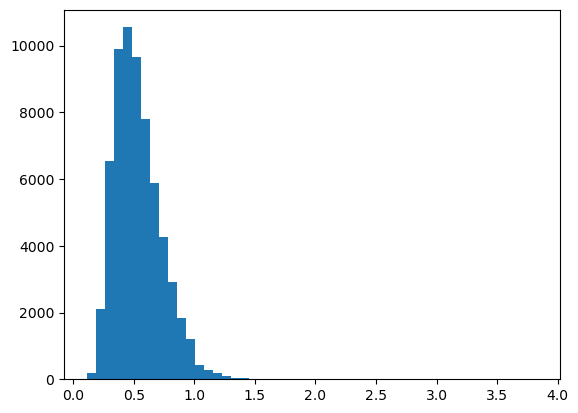

In [40]:
plt.hist(df['expansions_ratio'], bins=50)
plt.show()

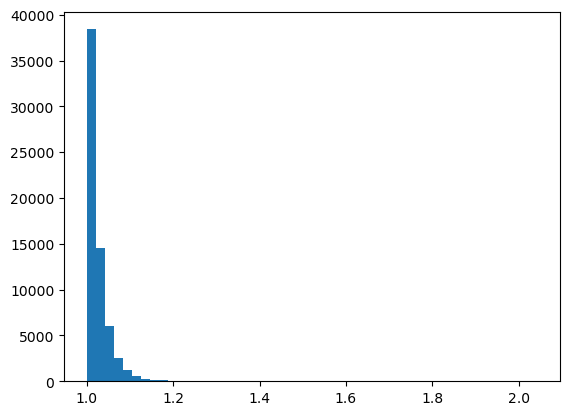

In [41]:
plt.hist(df['length_ratio'], bins=50)
plt.show()

In [42]:
print(df[df['expansions_ratio'] < 1]['length_ratio'].max())

1.7657744766813528


In [43]:
print(df['length_ratio'].max())

2.043331299491888


# Bug Traps

In [11]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './bug_traps/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_0.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./bug_traps_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:30<00:00, 45.26it/s]


In [58]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './bug_traps/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_default.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

default_df = pd.read_csv('./bug_traps_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / default_df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / default_df['expanded_nodes_num'][i])

/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide                    | 0/4096 [00:00<?, ?it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_2154642/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(self.f - other.f) < epsilon: # tie-break
/tmp/ipykernel_2154642/3792952004.py:43: RuntimeWarning: divide by zero encountered in scalar divide           | 27/4096 [00:01<02:39, 25.49it/s]
  start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: invalid value encountered in scalar divide            | 73/4096 [00:03<02:28, 27.04it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best

In [33]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './bug_traps/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_big_2.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./bug_traps_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:51<00:00, 79.83it/s]


In [34]:
big_df = pd.DataFrame.from_dict(metrics)
df.head()

,path_length,expanded_nodes_num
0,74.455844,776
1,73.769553,760
2,81.870058,641
3,92.183766,832
4,62.355339,432


In [12]:
df = pd.DataFrame.from_dict(metrics)
df.head()

,expansions_ratio,length_ratio
0,0.938144,1.201066
1,1.518421,1.411888
2,0.661466,1.151274
3,0.712740,1.175108
4,1.018519,1.209622


In [59]:
default_df = pd.DataFrame.from_dict(metrics)
default_df.head()

,expansions_ratio,length_ratio
0,1.051546,1.251531
1,3.057895,1.384776
2,1.129485,1.391372
3,1.944712,1.696259
4,1.407407,1.553045


In [19]:
print((big_df['expansions_ratio'] < 1).mean())

0.989990234375


In [60]:
print((default_df['expansions_ratio'] < 1).mean())

0.283447265625


In [13]:
print((df['expansions_ratio'] < 1).mean())

0.690185546875


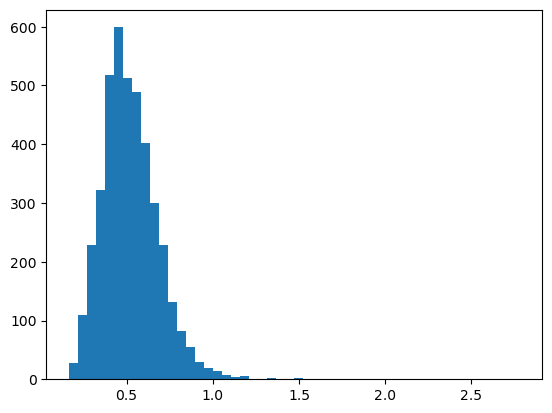

In [35]:
plt.hist(big_df['expansions_ratio'], bins=50)
plt.show()

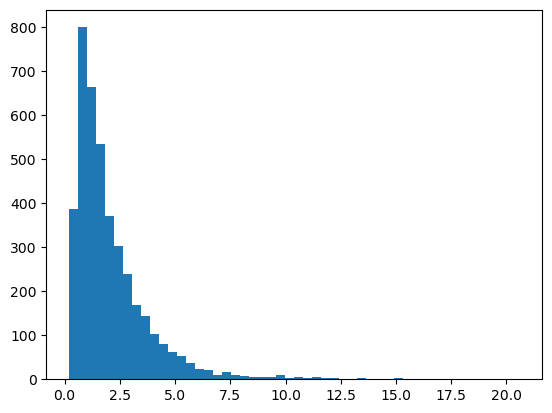

In [61]:
plt.hist(default_df['expansions_ratio'], bins=50)
plt.show()

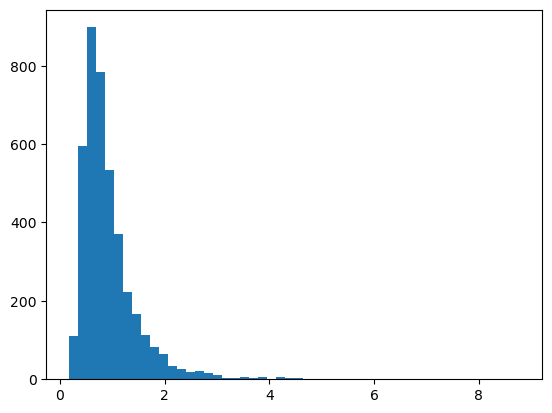

In [14]:
plt.hist(df['expansions_ratio'], bins=50)
plt.show()

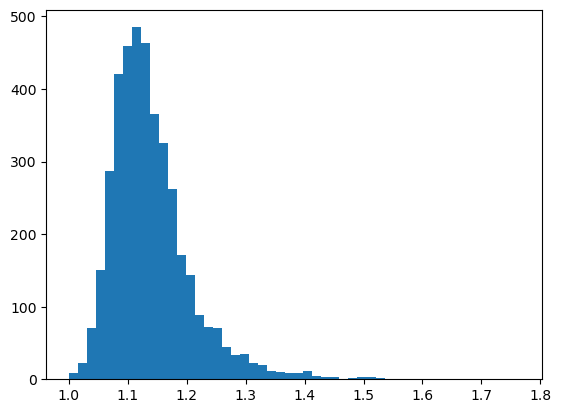

In [26]:
plt.hist(big_df['length_ratio'], bins=50)
plt.show()

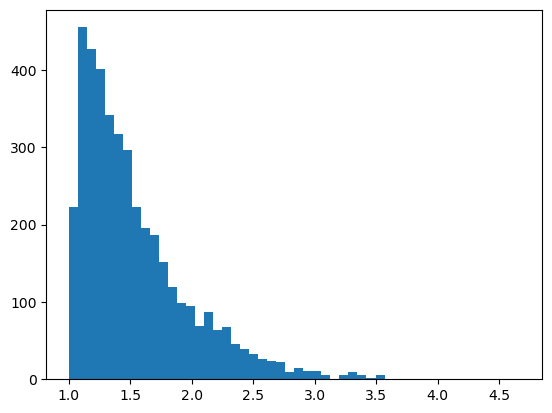

In [62]:
plt.hist(default_df['length_ratio'], bins=50)
plt.show()

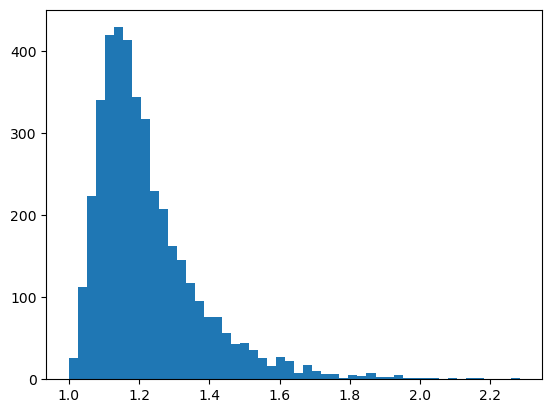

In [15]:
plt.hist(df['length_ratio'], bins=50)
plt.show()

In [27]:
print(big_df[big_df['expansions_ratio'] < 1]['length_ratio'].max())

1.440465874383604


In [63]:
print(default_df[default_df['expansions_ratio'] < 1]['length_ratio'].max())

2.956028036141887


In [16]:
print(df[df['expansions_ratio'] < 1]['length_ratio'].max())

1.8114443474103261


In [28]:
print(big_df['length_ratio'].max())

1.7651904437648323


In [64]:
print(default_df['length_ratio'].max())

4.668437236882734


In [17]:
print(df['length_ratio'].max())

2.283913971863063


# Bands

In [12]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './bands/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_0.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./bands_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [02:19<00:00, 29.29it/s]


In [65]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './bands/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_default.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

default_df = pd.read_csv('./bands_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / default_df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / default_df['expanded_nodes_num'][i])

/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide                    | 0/4096 [00:00<?, ?it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_2154642/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(self.f - other.f) < epsilon: # tie-break
/tmp/ipykernel_2154642/3792952004.py:43: RuntimeWarning: divide by zero encountered in scalar divide           | 10/4096 [00:00<04:48, 14.16it/s]
  start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [03:35<00:00, 18.98it/s]


In [12]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './bands/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_big_2.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./bands_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

/tmp/ipykernel_1341116/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide           | 17/4096 [00:00<03:22, 20.12it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_1341116/3792952004.py:57: RuntimeWarning: invalid value encountered in scalar divide            | 23/4096 [00:01<03:06, 21.89it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_1341116/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract          | 27/4096 [00:01<03:11, 21.28it/s]
  if abs(self.f - other.f) < epsilon: # tie-break
/tmp/ipykernel_1341116/3792952004.py:43: Runtime

In [13]:
big_df = pd.DataFrame.from_dict(metrics)
df.head()

,path_length,expanded_nodes_num
0,213.870058,1054
1,100.526912,1074
2,86.112698,746
3,104.183766,773
4,155.497475,1501


In [13]:
df = pd.DataFrame.from_dict(metrics)
df.head()

,expansions_ratio,length_ratio
0,1.000949,1.009351
1,0.400372,1.000000
2,0.197051,1.000000
3,0.443726,1.024819
4,0.353098,1.009095


In [66]:
default_df = pd.DataFrame.from_dict(metrics)
default_df.head()

,expansions_ratio,length_ratio
0,1.055028,1.111748
1,0.965549,1.795807
2,0.398123,1.203876
3,0.860285,1.088033
4,1.018654,1.011302


In [14]:
print((big_df['expansions_ratio'] < 1).mean())

0.81494140625


In [67]:
print((default_df['expansions_ratio'] < 1).mean())

0.766357421875


In [14]:
print((df['expansions_ratio'] < 1).mean())

0.949462890625


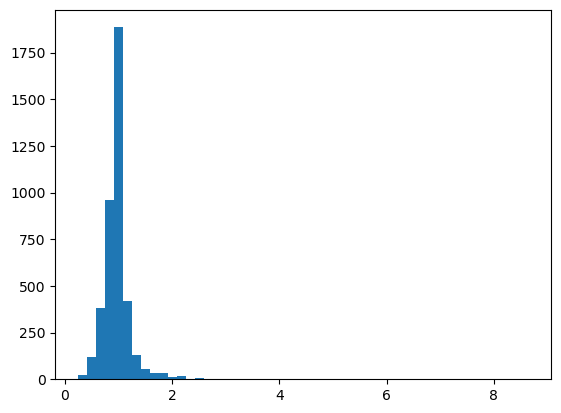

In [34]:
plt.hist(big_df['expansions_ratio'], bins=50)
plt.show()

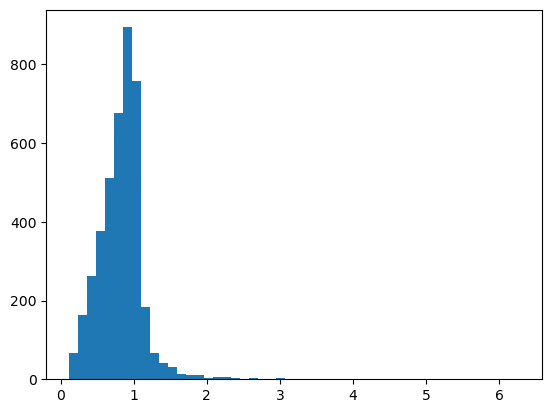

In [68]:
plt.hist(default_df['expansions_ratio'], bins=50)
plt.show()

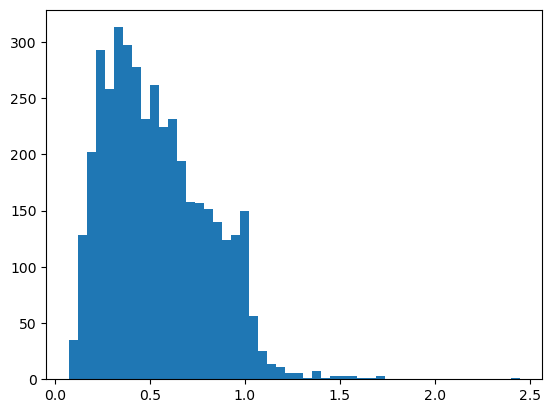

In [15]:
plt.hist(df['expansions_ratio'], bins=50)
plt.show()

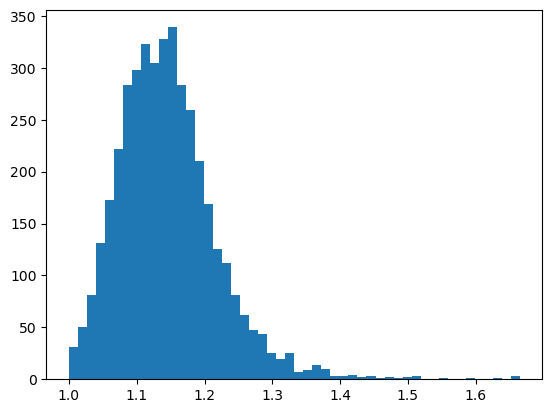

In [35]:
plt.hist(big_df['length_ratio'], bins=50)
plt.show()

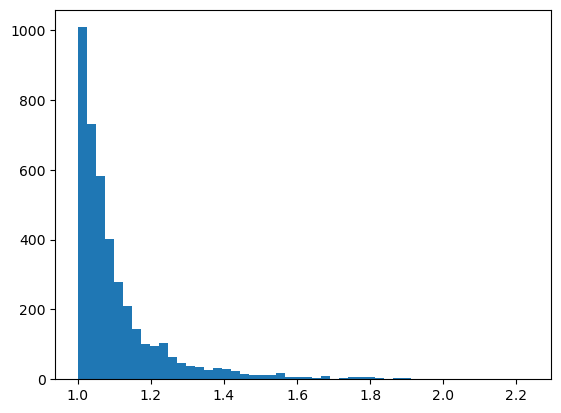

In [69]:
plt.hist(default_df['length_ratio'], bins=50)
plt.show()

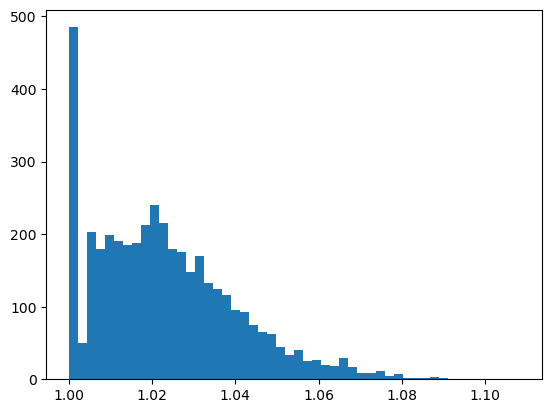

In [16]:
plt.hist(df['length_ratio'], bins=50)
plt.show()

In [37]:
print(big_df[big_df['expansions_ratio'] < 1]['length_ratio'].max())

1.6522641454669074


In [70]:
print(default_df[default_df['expansions_ratio'] < 1]['length_ratio'].max())

2.2338089236416083


In [17]:
print(df[df['expansions_ratio'] < 1]['length_ratio'].max())

1.1083107934525749


In [38]:
print(big_df['length_ratio'].max())

1.6648825908167981


In [72]:
print(default_df['length_ratio'].max())

2.2338089236416083


In [18]:
print(df['length_ratio'].max())

1.1083107934525749


# Caves

In [21]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './caves/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_0.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./caves_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:19<00:00, 207.23it/s]


In [73]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './caves/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_default.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

default_df = pd.read_csv('./caves_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / default_df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / default_df['expanded_nodes_num'][i])

/tmp/ipykernel_2154642/3792952004.py:43: RuntimeWarning: divide by zero encountered in scalar divide          | 81/4096 [00:00<00:29, 134.14it/s]
  start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_2154642/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(self.f - other.f) < epsilon: # tie-break
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:32<00:00, 125.11it/s]


In [36]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './caves/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_big_2.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./caves_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

 10%|██████████                                                                                               | 392/4096 [00:04<00:43, 84.62it/s]


KeyboardInterrupt: 

In [23]:
big_df = pd.DataFrame.from_dict(metrics)
big_df.head()

,expansions_ratio,length_ratio
0,0.894366,1.033787
1,0.883853,1.087884
2,0.424116,1.113656
3,1.233083,1.195563
4,1.238532,1.044427


In [22]:
df = pd.DataFrame.from_dict(metrics)
df.head()

,expansions_ratio,length_ratio
0,0.492958,1.000000
1,0.249292,1.000000
2,0.259875,1.026169
3,0.518797,1.000000
4,0.871560,1.000000


In [74]:
default_df = pd.DataFrame.from_dict(metrics)
default_df.head()

,expansions_ratio,length_ratio
0,0.760563,1.038453
1,0.294618,1.010662
2,0.297297,1.018504
3,0.812030,1.019362
4,1.467890,1.061032


In [24]:
print((big_df['expansions_ratio'] < 1).mean())

0.526611328125


In [75]:
print((default_df['expansions_ratio'] < 1).mean())

0.734619140625


In [23]:
print((df['expansions_ratio'] < 1).mean())

0.9697265625


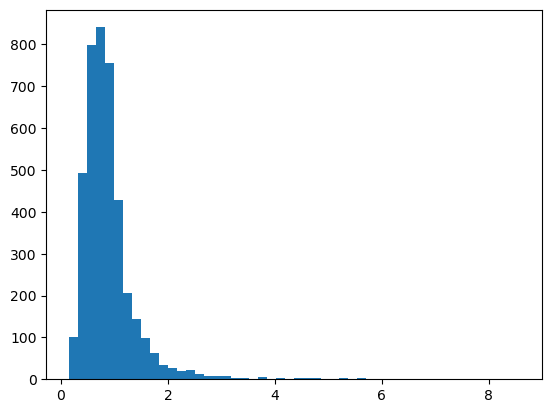

In [76]:
plt.hist(default_df['expansions_ratio'], bins=50)
plt.show()

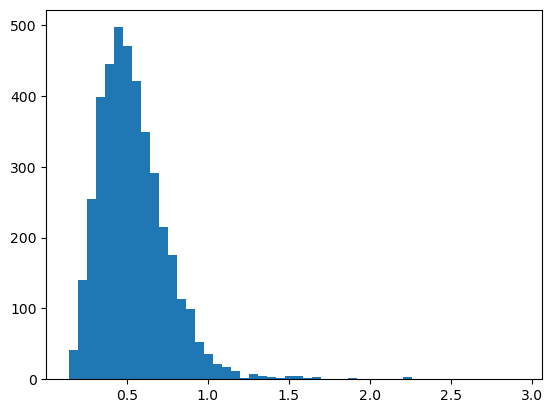

In [24]:
plt.hist(df['expansions_ratio'], bins=50)
plt.show()

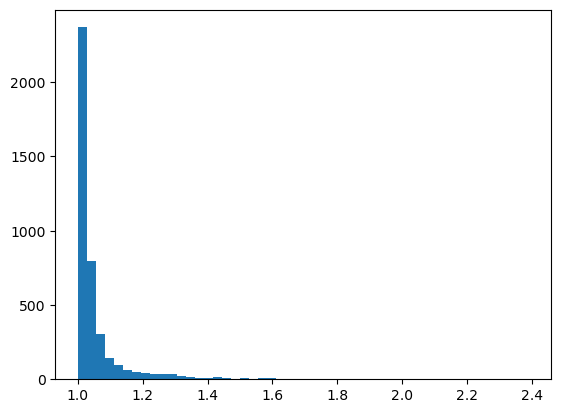

In [77]:
plt.hist(default_df['length_ratio'], bins=50)
plt.show()

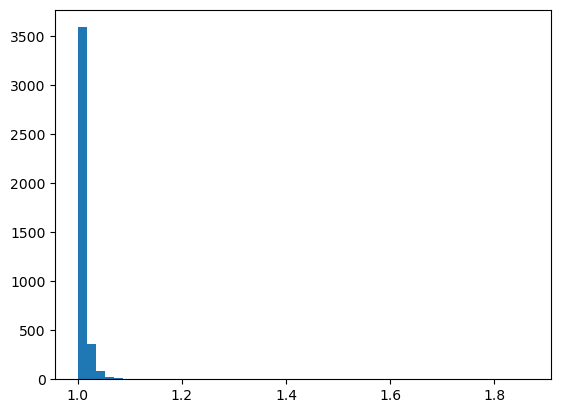

In [25]:
plt.hist(df['length_ratio'], bins=50)
plt.show()

In [80]:
print(default_df[default_df['expansions_ratio'] < 1]['length_ratio'].max())

1.978016364280888


In [26]:
print(df[df['expansions_ratio'] < 1]['length_ratio'].max())

1.3494022864536126


In [81]:
print(default_df['length_ratio'].max())

2.3894901664965706


In [27]:
print(df['length_ratio'].max())

1.8659342936383059


# Islands

In [31]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './islands/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_0.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./islands_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:30<00:00, 134.20it/s]


In [82]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './islands/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_default.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

default_df = pd.read_csv('./islands_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / default_df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / default_df['expanded_nodes_num'][i])

/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide           | 26/4096 [00:00<00:44, 91.06it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_2154642/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract          | 47/4096 [00:00<00:43, 94.11it/s]
  if abs(self.f - other.f) < epsilon: # tie-break
/tmp/ipykernel_2154642/3792952004.py:43: RuntimeWarning: divide by zero encountered in scalar divide          | 760/4096 [00:08<00:38, 86.68it/s]
  start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:46<00:00, 87.41it/s]


In [27]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './islands/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_big_2.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./islands_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

/tmp/ipykernel_1341116/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide           | 80/4096 [00:00<00:46, 86.70it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_1341116/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract         | 574/4096 [00:06<00:37, 94.43it/s]
  if abs(self.f - other.f) < epsilon: # tie-break
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:47<00:00, 85.86it/s]


In [28]:
big_df = pd.DataFrame.from_dict(metrics)
big_df.head()

,expansions_ratio,length_ratio
0,1.803571,1.820895
1,1.582857,1.459804
2,0.501247,1.173486
3,0.889313,1.098155
4,0.554745,1.075729


In [32]:
df = pd.DataFrame.from_dict(metrics)
df.head()

,expansions_ratio,length_ratio
0,1.458333,1.653782
1,1.080000,1.000000
2,1.102244,1.323083
3,0.916031,1.280461
4,0.669100,1.140368


In [83]:
default_df = pd.DataFrame.from_dict(metrics)
default_df.head()

,expansions_ratio,length_ratio
0,1.476190,1.693776
1,0.851429,1.106738
2,0.992519,1.161542
3,1.003817,1.038651
4,1.109489,1.323194


In [29]:
print((big_df['expansions_ratio'] < 1).mean())

0.42724609375


In [84]:
print((default_df['expansions_ratio'] < 1).mean())

0.406982421875


In [33]:
print((df['expansions_ratio'] < 1).mean())

0.7578125


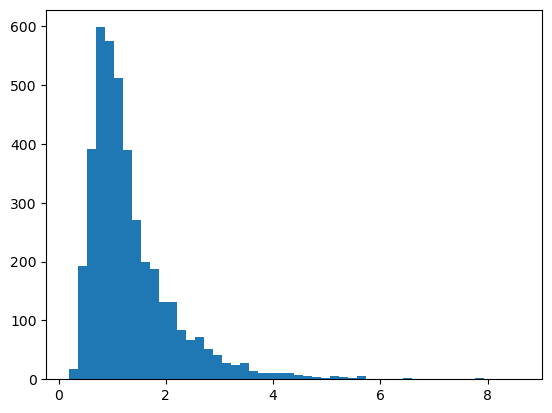

In [85]:
plt.hist(default_df['expansions_ratio'], bins=50)
plt.show()

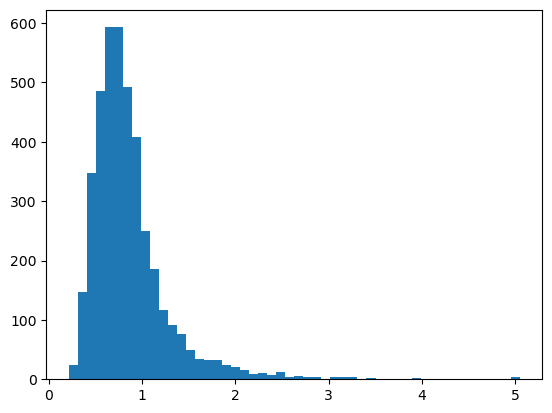

In [35]:
plt.hist(df['expansions_ratio'], bins=50)
plt.show()

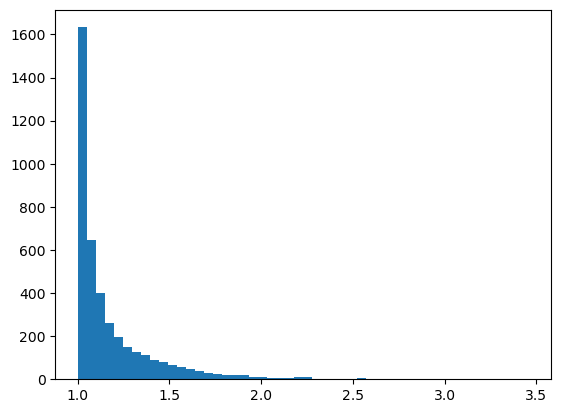

In [86]:
plt.hist(default_df['length_ratio'], bins=50)
plt.show()

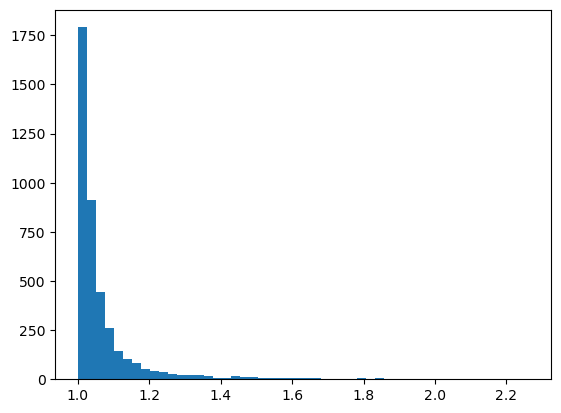

In [34]:
plt.hist(df['length_ratio'], bins=50)
plt.show()

In [87]:
print(default_df[default_df['expansions_ratio'] < 1]['length_ratio'].max())

1.750069711229375


In [36]:
print(df[df['expansions_ratio'] < 1]['length_ratio'].max())

1.4858662064633075


In [88]:
print(default_df['length_ratio'].max())

3.4583823242595093


In [37]:
print(df['length_ratio'].max())

2.262357449578861


# QRs

In [40]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './QRs/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_0.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

df = pd.read_csv('./QRs_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / df['expanded_nodes_num'][i])

/tmp/ipykernel_2154642/3792952004.py:43: RuntimeWarning: divide by zero encountered in scalar divide          | 174/4096 [00:02<00:51, 76.75it/s]
  start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_2154642/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(self.f - other.f) < epsilon: # tie-break
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:50<00:00, 80.94it/s]


In [89]:
dataset_path = '../HS_HW_TransPath/TransPath_AlekSet/train'
dataset_path = './QRs/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
heuristics = np.load(f'{dataset_path}/predicted_cf_default.npy', mmap_mode='c')
targets = np.load(f'{dataset_path}/cf.npy', mmap_mode='c')

metrics = {'expansions_ratio' : [], 'length_ratio' : []}

default_df = pd.read_csv('./QRs_astar_octile_tie_break_data.csv')

for i in tqdm(range(cells.shape[0])):
    map = Map(cells[i, 0])
    start_i, start_j = np.where(starts[i, 0])
    start_i, start_j = start_i[0], start_j[0]
    goal_i, goal_j = np.where(goals[i, 0])
    goal_i, goal_j = goal_i[0], goal_j[0]
    data = wastar(map, start_i, start_j, goal_i, goal_j, octile_distance, heuristics[i, 0], SearchTreePQD)
    assert data[0], draw(map, Node(start_i, start_j), Node(goal_i, goal_j))
    path, length = make_path(data[1])
    metrics['length_ratio'].append(length / default_df['path_length'][i])
    metrics['expansions_ratio'].append(len(data[-1]) / default_df['expanded_nodes_num'][i])

/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: divide by zero encountered in scalar divide                    | 0/4096 [00:00<?, ?it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j) / heuristic[neighbour[0], neighbour[1]], parent=best)
/tmp/ipykernel_2154642/3792952004.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j) / heuristic[start_i, start_j])
/tmp/ipykernel_2154642/1836098995.py:74: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(self.f - other.f) < epsilon: # tie-break
/tmp/ipykernel_2154642/3792952004.py:57: RuntimeWarning: invalid value encountered in scalar divide            | 12/4096 [00:00<02:25, 28.10it/s]
  cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0

In [41]:
df = pd.DataFrame.from_dict(metrics)
df.head()

,expansions_ratio,length_ratio
0,0.642857,1.000000
1,0.659836,1.403274
2,0.553047,1.339789
3,2.815574,1.767906
4,0.958929,1.265102


In [90]:
default_df = pd.DataFrame.from_dict(metrics)
default_df.head()

,expansions_ratio,length_ratio
0,2.142857,1.000000
1,1.459016,1.298906
2,1.205418,1.284732
3,3.856557,1.436424
4,1.267857,1.364811


In [91]:
print((default_df['expansions_ratio'] < 1).mean())

0.139892578125


In [42]:
print((df['expansions_ratio'] < 1).mean())

0.5537109375


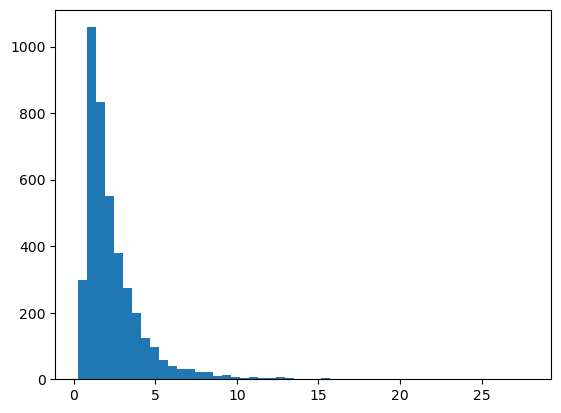

In [92]:
plt.hist(default_df['expansions_ratio'], bins=50)
plt.show()

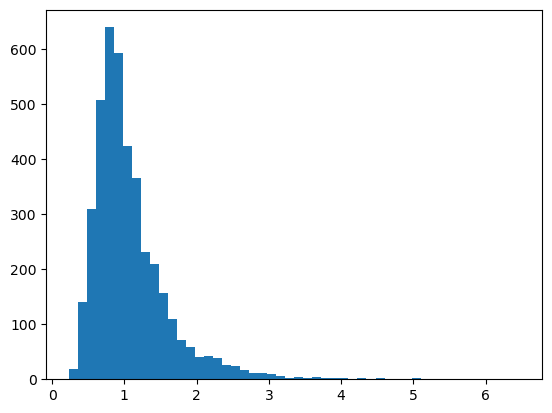

In [43]:
plt.hist(df['expansions_ratio'], bins=50)
plt.show()

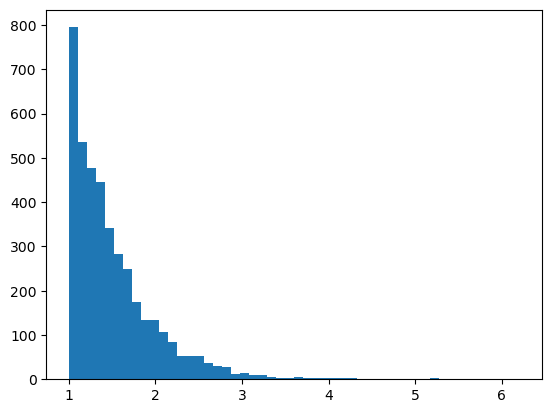

In [93]:
plt.hist(default_df['length_ratio'], bins=50)
plt.show()

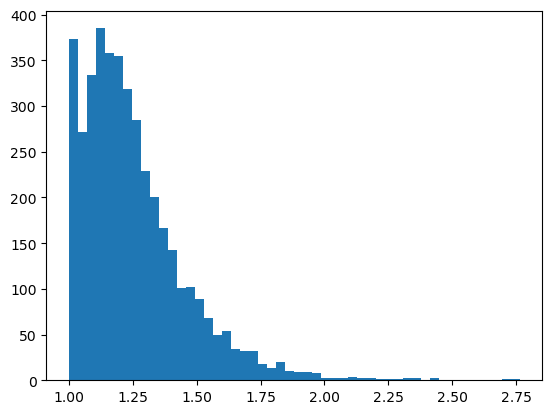

In [44]:
plt.hist(df['length_ratio'], bins=50)
plt.show()

In [94]:
print(default_df[default_df['expansions_ratio'] < 1]['length_ratio'].max())

2.0543874106538578


In [45]:
print(df[df['expansions_ratio'] < 1]['length_ratio'].max())

2.340647287656579


In [95]:
print(default_df['length_ratio'].max())

6.208787496255522


In [46]:
print(df['length_ratio'].max())

2.764336317965202
